(48, 48, 3) scale up to (96, 96, 3) by srGAN

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import cv2
import matplotlib.pyplot as plt
from imutils import paths
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG19

In [2]:
list_ds = tf.data.Dataset.list_files('./faces/*')
for f in list_ds.take(5):
    print(f.numpy())

b'./faces/3569.jpg'
b'./faces/45951.jpg'
b'./faces/41716.jpg'
b'./faces/33095.jpg'
b'./faces/66715.jpg'


In [3]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image

def preprocess_image(file_path):
    images = tf.io.read_file(file_path)
    images = tf.image.decode_jpeg(images, channels=3)
#     images = tf.image.resize(images, (48, 48))
    images = normalize(images)
    return images

In [4]:
BS = 128
dataset = list_ds.map(preprocess_image).shuffle(1024).batch(BS)

In [5]:
@tf.function
def downsampling(hr_image):
#     lr_image = tfa.image.gaussian_filter2d(hr_image, (5, 5), 0)
#     hr_image = hr_image + tf.random.normal(shape=tf.shape(hr_image),mean=0,stddev=0.2)
    lr_image = tf.image.resize(hr_image, (48, 48))
    return lr_image

In [6]:
tf.keras.backend.clear_session()

In [7]:

def residual_block(x, filters=64, kernel_size=3):
    y = Conv2D(filters, kernel_size, padding='same')(x)
    y = BatchNormalization()(y)
    y = PReLU()(y)
    y = Conv2D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)
    y = add([x, y])
    return y

def build_generator(input_shape=(48, 48, 3)):

    input_layer = Input(input_shape)
    
    x = Conv2D(64, (9, 9), padding='same')(input_layer)
    x = PReLU()(x)
    
    temp = x
    
    for i in range(5):
        x = residual_block(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = add([temp, x])

    x = UpSampling2D((2,2))(x)
    
    x = Conv2DTranspose(3, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    output = Activation('tanh')(x)
    
    model = Model(inputs=input_layer, outputs=output)
    return model

generator = build_generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 48, 48, 64)   147456      ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 48, 48, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

                                                                                                  
 conv2d_11 (Conv2D)             (None, 48, 48, 64)   36928       ['add_4[0][0]']                  
                                                                                                  
 batch_normalization_10 (BatchN  (None, 48, 48, 64)  256         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_5 (Add)                    (None, 48, 48, 64)   0           ['p_re_lu[0][0]',                
                                                                  'batch_normalization_10[0][0]'] 
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 96, 96, 64)   0           ['add_5[0][0]']                  
          

In [8]:
VGG_Model = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(96, 96, 3)))
headModel = VGG_Model.output
headModel = Flatten()(headModel)
headModel = Dense(1)(headModel)

discriminator = Model(inputs=VGG_Model.input, outputs=[VGG_Model.layers[10].output, headModel])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0   

In [9]:
optG = keras.optimizers.legacy.Adam(learning_rate=0.0001)
optD = keras.optimizers.legacy.Adam(learning_rate=0.00001)

content_lossG = keras.losses.MeanSquaredError()
adversarial_lossG = keras.losses.BinaryCrossentropy()
adversarial_lossD = keras.losses.BinaryCrossentropy(from_logits=True)

In [10]:
## train disciminator to classify original img and gerenated img
@tf.function
def trainDStep(data):
    BS = tf.shape(data)[0] 
    y_true = tf.concat([
            tf.ones(BS, 1),    # label 1 : real image
            tf.zeros(BS, 1),   # label 0 : generated image
        ], axis=0)
#     data = data.numpy()
    LR = downsampling(data)
    
    with tf.GradientTape() as tape:
        fake = generator(LR)
        x  = tf.concat([data, fake], axis=0)
        _, y_pred = discriminator(x)
        discriminatorLoss = adversarial_lossD(y_true, y_pred)
        
    grad = tape.gradient(discriminatorLoss, discriminator.trainable_variables)
    optD.apply_gradients(zip(grad, discriminator.trainable_variables))
    
    return{
        'discriminator_loss' : discriminatorLoss
    }

In [11]:
## train generator make fake img
@tf.function
def trainGStep(data):
    y_true = tf.ones(tf.shape(data)[0], 1)
    HR = data
    LR = downsampling(data) ## TODO
    
    with tf.GradientTape() as tape:
        fake = generator(LR)
        lr_featuremap, y_pred = discriminator(fake)
        hr_featuremap, _      = discriminator(HR)
        
        adversarial_loss = adversarial_lossG(y_true, y_pred)
        content_loss = content_lossG(hr_featuremap, lr_featuremap)
        total_loss = content_loss + 1e-3*adversarial_loss
    
    grad = tape.gradient(total_loss, generator.trainable_variables)
    optG.apply_gradients(zip(grad, generator.trainable_variables))
    
    return{
        'generator_loss' : total_loss
    }

In [12]:
def plot_result():
    it = iter(dataset)
    ds = next(it).numpy()
    ds = ds[0:4]
    
    LR = downsampling(ds)
    fake = generator(LR)
    
    plt.figure(figsize=(4, 6))
    for i in range(4):

        plt.subplot(4, 3, i*3+1)
        plt.title('LR')
        plt.imshow(np.clip(LR[i],0,1))
        plt.axis('off')

        plt.subplot(4, 3, i*3+2)
        plt.title('srGAN')
        plt.imshow(np.clip(fake[i],0,1))
        plt.axis('off')
        
        plt.subplot(4, 3, i*3+3)
        plt.title('HR')
        plt.imshow(np.clip(ds[i],0,1))
        plt.axis('off')    

    plt.tight_layout()
    plt.show()

epoch:0        DiscriminatorLoss:0.04        GeneratorLoss:31.64


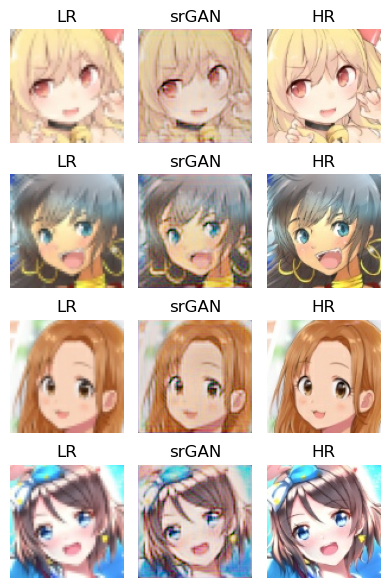

epoch:1        DiscriminatorLoss:0.04        GeneratorLoss:8.99
epoch:2        DiscriminatorLoss:0.04        GeneratorLoss:5.17
epoch:3        DiscriminatorLoss:0.04        GeneratorLoss:3.86
epoch:4        DiscriminatorLoss:0.03        GeneratorLoss:3.34
epoch:5        DiscriminatorLoss:0.03        GeneratorLoss:3.00


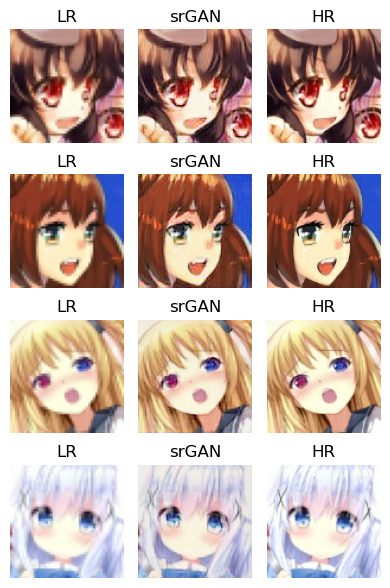

epoch:6        DiscriminatorLoss:0.05        GeneratorLoss:2.62
epoch:7        DiscriminatorLoss:0.02        GeneratorLoss:2.46
epoch:8        DiscriminatorLoss:0.03        GeneratorLoss:2.29
epoch:9        DiscriminatorLoss:0.02        GeneratorLoss:2.20


In [13]:
for epoch in range(10):
    dLossSum = 0
    gLossSum = 0
    cnt = 0
    
    for batch in dataset:
        dLoss = trainDStep(batch)
        dLossSum += dLoss['discriminator_loss']
        gLoss = trainGStep(batch)
        gLossSum += gLoss['generator_loss']
        
        cnt += 1
        
    print(f'epoch:{epoch}        DiscriminatorLoss:{dLossSum/cnt :.2f}        GeneratorLoss:{gLossSum/cnt :.2f}')
    
    if epoch % 5 == 0:
        plot_result()

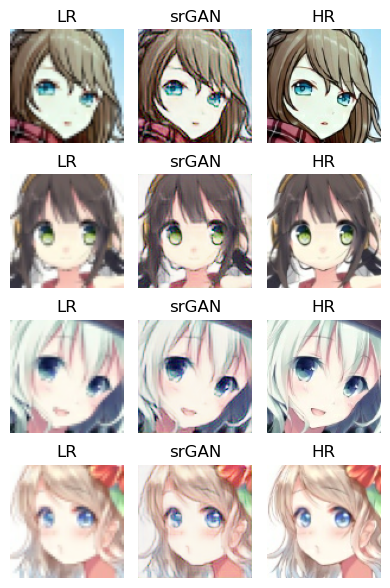

In [14]:
plot_result()

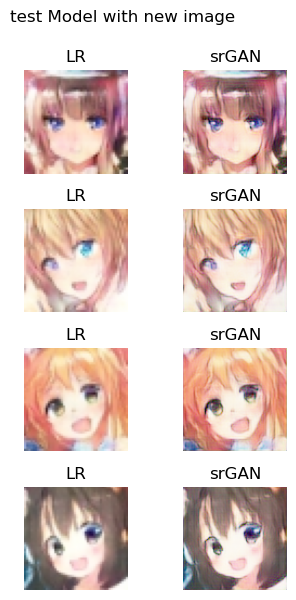

In [34]:
filenames = ['2.jpeg', '34.jpeg', '46.jpeg', '69.jpeg']
ds = []
for filename in filenames:
    img = cv2.imread('./generated_image/'+filename)
    img = cv2.resize(img, (48, 48))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ds.append(img/255.0)
ds = np.array(ds)

LR = ds
fake = generator(LR)

plt.figure(figsize=(5,6))
plt.suptitle('test Model with new image',ha='right', va='center')
for i in range(4):

    plt.subplot(4, 3, i*3+1)
    plt.title('LR')
    plt.imshow(np.clip(LR[i],0,1))
    plt.axis('off')

    plt.subplot(4, 3, i*3+2)
    plt.title('srGAN')
    plt.imshow(np.clip(fake[i],0,1))
    plt.axis('off')

plt.tight_layout()
plt.show()